In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as ur
from bbmag import bb_abmag, gettempbb
from tdsat_sensitivity import find_limit, compute_snr
from tdsat_telescope import load_telescope_parameters
from astropy.visualization import quantity_support
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [15,10]

In [3]:
# Setup:
td1_band = [[180,220],[193,220],[193,240]]*ur.nm

td2_bandwidth = [40,60,80,100,120,140,160,180,200]
td2 = []
for w in td2_bandwidth:
    td2.append([260,260+w])
    
td2_band = td2*ur.nm
    
bbtemp = [15000,20000,30000]*ur.K

dist = [100,200]*ur.Mpc

# For the shock model after 1 hr:
swiftmag_sh = -16.5*ur.ABmag

# For the blue kilonova model after 1 hr:
swiftmag_bk = -13.6*ur.ABmag

# Satellite details:
diameter, qe, psf_fwhm, pixel_size, efficiency = load_telescope_parameters(6, diag=True)
outofband_qe = 0.0001
exposure = 300*ur.s

Telescope Configuration 6
Name: Two mini Big Schmidts
Entrance Pupil diameter 21.0 cm
Optical Effifiency 0.5170294784580499
PSF FWHM 2.8810000000000002 arcsec
Pixel size 4.3 arcsec
Effective Aperture 15.1 cm
Effective Area 179.0786352362522 cm2


In [4]:
# Calculate magnitudes in different bands for the shock model:
bbmag_sh = np.zeros([len(bbtemp),len(td1_band),len(td2_band),len(dist),2])
for i in range(len(bbtemp)):
    for j in range(len(td2_band)):
        for h in range(len(td1_band)):
            for k in range(len(dist)):
                bbmag_sh[i,h,j,k] = bb_abmag(bbtemp=bbtemp[i], bandone=td1_band[h], 
                                  bandtwo=td2_band[j], swiftmag=swiftmag_sh, 
                                  dist=dist[k], val=True)
            
bbmag_sh = bbmag_sh*ur.ABmag

In [5]:
# Same for the blue kilonova:
bbmag_bk = np.zeros([len(bbtemp),len(td1_band),len(td2_band),len(dist),2])
for i in range(len(bbtemp)):
    for j in range(len(td2_band)):
        for h in range(len(td1_band)):
            for k in range(len(dist)):
                bbmag_bk[i,h,j,k] = bb_abmag(bbtemp=bbtemp[i], bandone=td1_band[h], 
                                  bandtwo=td2_band[j], swiftmag=swiftmag_bk, 
                                  dist=dist[k], val=True)

bbmag_bk = bbmag_bk*ur.ABmag

In [6]:
# Calculate signal-to-noise for each band for the shock model (this is quite slow):
snrs_sh = np.zeros([len(bbtemp),len(td1_band),len(td2_band),len(dist),2])
for i in range(len(bbtemp)):   
    for k in range(len(dist)):
        for h in range(len(td1_band)):
            for j in range(len(td2_band)):
                snrs_sh[i,h,j,k,0] = compute_snr(td1_band[h],bbmag_sh[i,h,j,k,0],
                                  low_zodi=True, diameter=diameter,
                                  exposure = exposure, pixel_size = pixel_size,
                                  efficiency = efficiency, qe = qe,
                                  outofband_qe = outofband_qe, psf_size = psf_fwhm)

                snrs_sh[i,h,j,k,1] = compute_snr(td2_band[j],bbmag_sh[i,h,j,k,1],
                                  low_zodi=True,diameter=diameter,
                                  exposure = exposure, pixel_size = pixel_size,
                                  efficiency = efficiency, qe = qe,
                                  outofband_qe = outofband_qe, psf_size = psf_fwhm)
        
# Now into magnitude errors:
sigs_sh = 2.5*np.log10(1.+1./snrs_sh)*ur.ABmag

/Users/mheida/software/miniconda2/envs/envpy3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [7]:
# And for the blue kilonova:
snrs_bk = np.zeros([len(bbtemp),len(td1_band),len(td2_band),len(dist),2])
for i in range(len(bbtemp)):   
    for k in range(len(dist)):
        for h in range(len(td1_band)):
            for j in range(len(td2_band)):
                snrs_bk[i,h,j,k,0] = compute_snr(td1_band[h],bbmag_bk[i,h,j,k,0],
                                  low_zodi=True,diameter=diameter,
                                  exposure = exposure, pixel_size = pixel_size,
                                  efficiency = efficiency, qe = qe,
                                  outofband_qe = outofband_qe, psf_size = psf_fwhm)
                
                snrs_bk[i,h,j,k,1] = compute_snr(td2_band[j],bbmag_bk[i,h,j,k,1],
                                  low_zodi=True,diameter=diameter,
                                  exposure = exposure, pixel_size = pixel_size,
                                  efficiency = efficiency, qe = qe,
                                  outofband_qe = outofband_qe, psf_size = psf_fwhm)
            
# Now into magnitude errors:
sigs_bk = 2.5*np.log10(1.+1./snrs_bk)*ur.ABmag

In [8]:
# Get blackbody temperatures and errors:
bbtemp_fit_sh = np.zeros([len(bbtemp),len(td1_band),len(td2_band),len(dist),2])*ur.K
for i in range(len(bbtemp)):
    for h in range(len(td1_band)):
        for j in range(len(td2_band)):
            for k in range(len(dist)):
                bbtemp_fit_sh[i,h,j,k] = gettempbb(bandone=td1_band[h], bandtwo=td2_band[j],
                                        magone=bbmag_sh[i,h,j,k,0], magtwo=bbmag_sh[i,h,j,k,1],
                                        magone_err=sigs_sh[i,h,j,k,0],magtwo_err=sigs_sh[i,h,j,k,1])

In [9]:
# For the blue kilonova model:
bbtemp_fit_bk = np.zeros([len(bbtemp),len(td1_band),len(td2_band),len(dist),2])*ur.K
for i in range(len(bbtemp)):
    for h in range(len(td1_band)):
        for j in range(len(td2_band)):
            for k in range(len(dist)):
                bbtemp_fit_bk[i,h,j,k] = gettempbb(bandone=td1_band[h], bandtwo=td2_band[j],
                                    magone=bbmag_bk[i,h,j,k,0], magtwo=bbmag_bk[i,h,j,k,1],
                                    magone_err=sigs_bk[i,h,j,k,0],magtwo_err=sigs_bk[i,h,j,k,1])

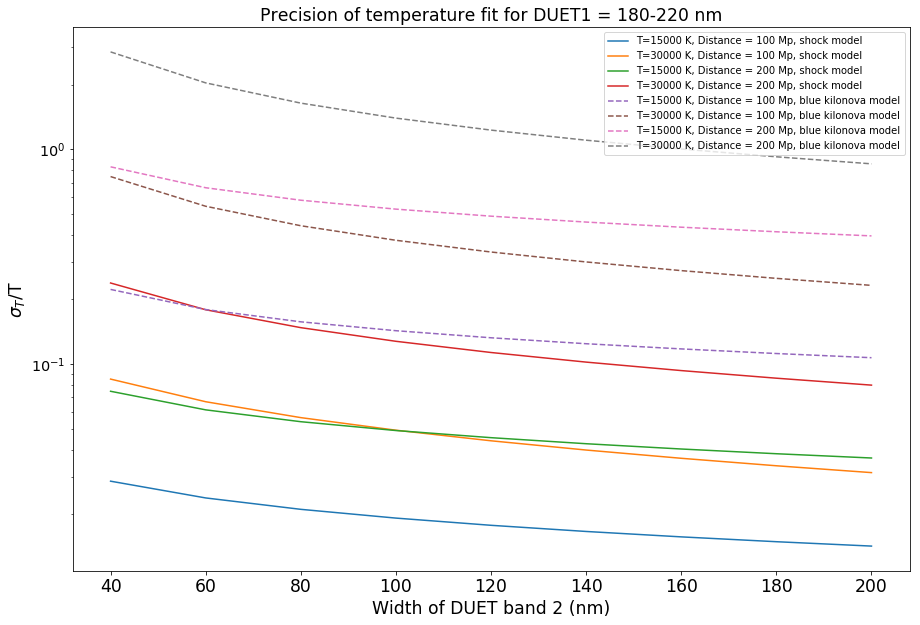

In [10]:
# Plot sigmaT/T as a function of bandwidth for TD2:
with quantity_support():
    plt.plot(td2_bandwidth,bbtemp_fit_sh[0,0,:,0,1]/bbtemp_fit_bk[0,0,:,0,0],linestyle='-',label='T=15000 K, Distance = 100 Mp, shock model')
    plt.plot(td2_bandwidth,bbtemp_fit_sh[2,0,:,0,1]/bbtemp_fit_bk[2,0,:,0,0],linestyle='-',label='T=30000 K, Distance = 100 Mp, shock model')
    plt.plot(td2_bandwidth,bbtemp_fit_sh[0,0,:,1,1]/bbtemp_fit_bk[0,0,:,1,0],linestyle='-',label='T=15000 K, Distance = 200 Mp, shock model')
    plt.plot(td2_bandwidth,bbtemp_fit_sh[2,0,:,1,1]/bbtemp_fit_bk[2,0,:,1,0],linestyle='-',label='T=30000 K, Distance = 200 Mp, shock model')
    plt.plot(td2_bandwidth,bbtemp_fit_bk[0,0,:,0,1]/bbtemp_fit_sh[0,0,:,0,0],linestyle='--',label='T=15000 K, Distance = 100 Mp, blue kilonova model')
    plt.plot(td2_bandwidth,bbtemp_fit_bk[2,0,:,0,1]/bbtemp_fit_sh[2,0,:,0,0],linestyle='--',label='T=30000 K, Distance = 100 Mp, blue kilonova model')
    plt.plot(td2_bandwidth,bbtemp_fit_bk[0,0,:,1,1]/bbtemp_fit_sh[0,0,:,1,0],linestyle='--',label='T=15000 K, Distance = 200 Mp, blue kilonova model')
    plt.plot(td2_bandwidth,bbtemp_fit_bk[2,0,:,1,1]/bbtemp_fit_sh[2,0,:,1,0],linestyle='--',label='T=30000 K, Distance = 200 Mp, blue kilonova model')
    
plt.legend()
plt.xlabel('Width of DUET band 2 (nm)',fontsize='xx-large')
plt.ylabel(r'$\sigma_T$/T',fontsize='xx-large')
plt.yscale('log')
plt.tick_params(axis='y',which='major',labelsize='x-large')
plt.tick_params(axis='x',which='major',labelsize='xx-large')
plt.title('Precision of temperature fit for DUET1 = 180-220 nm',fontsize='xx-large')
plt.show()

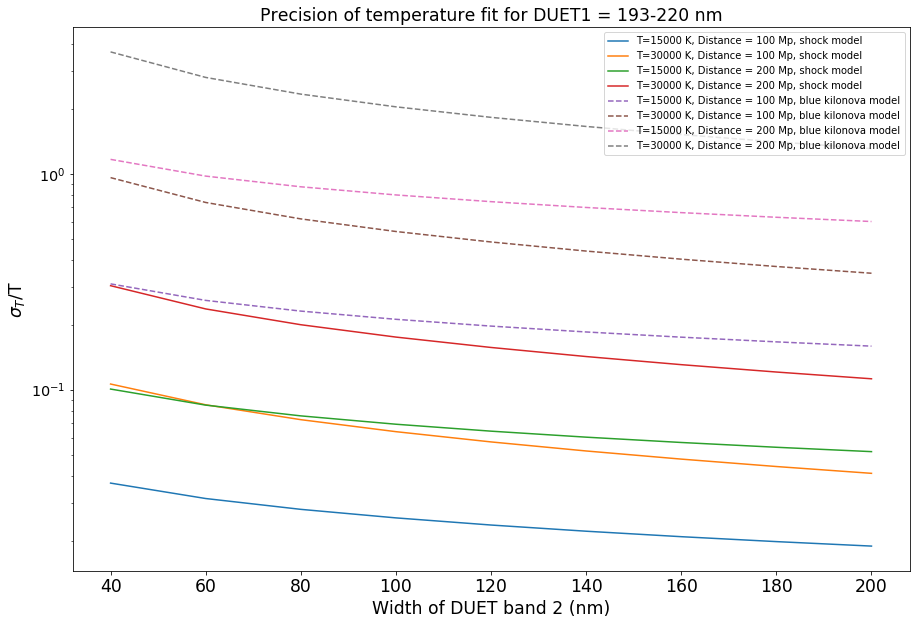

In [11]:
# Plot sigmaT/T as a function of bandwidth for TD2:
with quantity_support():
    plt.plot(td2_bandwidth,bbtemp_fit_sh[0,1,:,0,1]/bbtemp_fit_bk[0,1,:,0,0],linestyle='-',label='T=15000 K, Distance = 100 Mp, shock model')
    plt.plot(td2_bandwidth,bbtemp_fit_sh[2,1,:,0,1]/bbtemp_fit_bk[2,1,:,0,0],linestyle='-',label='T=30000 K, Distance = 100 Mp, shock model')
    plt.plot(td2_bandwidth,bbtemp_fit_sh[0,1,:,1,1]/bbtemp_fit_bk[0,1,:,1,0],linestyle='-',label='T=15000 K, Distance = 200 Mp, shock model')
    plt.plot(td2_bandwidth,bbtemp_fit_sh[2,1,:,1,1]/bbtemp_fit_bk[2,1,:,1,0],linestyle='-',label='T=30000 K, Distance = 200 Mp, shock model')
    plt.plot(td2_bandwidth,bbtemp_fit_bk[0,1,:,0,1]/bbtemp_fit_sh[0,1,:,0,0],linestyle='--',label='T=15000 K, Distance = 100 Mp, blue kilonova model')
    plt.plot(td2_bandwidth,bbtemp_fit_bk[2,1,:,0,1]/bbtemp_fit_sh[2,1,:,0,0],linestyle='--',label='T=30000 K, Distance = 100 Mp, blue kilonova model')
    plt.plot(td2_bandwidth,bbtemp_fit_bk[0,1,:,1,1]/bbtemp_fit_sh[0,1,:,1,0],linestyle='--',label='T=15000 K, Distance = 200 Mp, blue kilonova model')
    plt.plot(td2_bandwidth,bbtemp_fit_bk[2,1,:,1,1]/bbtemp_fit_sh[2,1,:,1,0],linestyle='--',label='T=30000 K, Distance = 200 Mp, blue kilonova model')
    
plt.legend()
plt.xlabel('Width of DUET band 2 (nm)',fontsize='xx-large')
plt.ylabel(r'$\sigma_T$/T',fontsize='xx-large')
plt.yscale('log')
plt.tick_params(axis='y',which='major',labelsize='x-large')
plt.tick_params(axis='x',which='major',labelsize='xx-large')
plt.title('Precision of temperature fit for DUET1 = 193-220 nm',fontsize='xx-large')
plt.show()

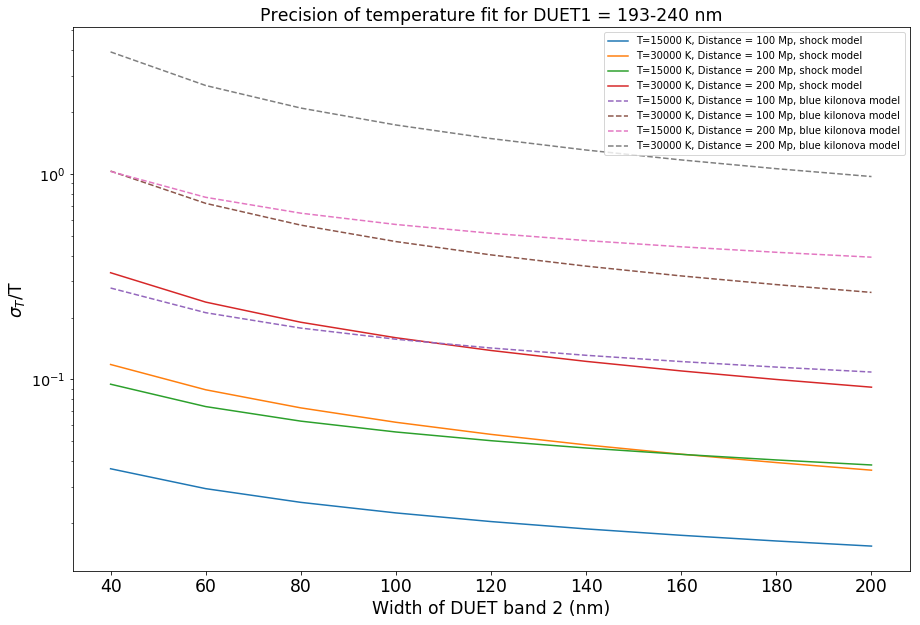

In [12]:
# Plot sigmaT/T as a function of bandwidth for TD2:
with quantity_support():
    plt.plot(td2_bandwidth,bbtemp_fit_sh[0,2,:,0,1]/bbtemp_fit_bk[0,2,:,0,0],linestyle='-',label='T=15000 K, Distance = 100 Mp, shock model')
    plt.plot(td2_bandwidth,bbtemp_fit_sh[2,2,:,0,1]/bbtemp_fit_bk[2,2,:,0,0],linestyle='-',label='T=30000 K, Distance = 100 Mp, shock model')
    plt.plot(td2_bandwidth,bbtemp_fit_sh[0,2,:,1,1]/bbtemp_fit_bk[0,2,:,1,0],linestyle='-',label='T=15000 K, Distance = 200 Mp, shock model')
    plt.plot(td2_bandwidth,bbtemp_fit_sh[2,2,:,1,1]/bbtemp_fit_bk[2,2,:,1,0],linestyle='-',label='T=30000 K, Distance = 200 Mp, shock model')
    plt.plot(td2_bandwidth,bbtemp_fit_bk[0,2,:,0,1]/bbtemp_fit_sh[0,2,:,0,0],linestyle='--',label='T=15000 K, Distance = 100 Mp, blue kilonova model')
    plt.plot(td2_bandwidth,bbtemp_fit_bk[2,2,:,0,1]/bbtemp_fit_sh[2,2,:,0,0],linestyle='--',label='T=30000 K, Distance = 100 Mp, blue kilonova model')
    plt.plot(td2_bandwidth,bbtemp_fit_bk[0,2,:,1,1]/bbtemp_fit_sh[0,2,:,1,0],linestyle='--',label='T=15000 K, Distance = 200 Mp, blue kilonova model')
    plt.plot(td2_bandwidth,bbtemp_fit_bk[2,2,:,1,1]/bbtemp_fit_sh[2,2,:,1,0],linestyle='--',label='T=30000 K, Distance = 200 Mp, blue kilonova model')
    
plt.legend()
plt.xlabel('Width of DUET band 2 (nm)',fontsize='xx-large')
plt.ylabel(r'$\sigma_T$/T',fontsize='xx-large')
plt.yscale('log')
plt.tick_params(axis='y',which='major',labelsize='x-large')
plt.tick_params(axis='x',which='major',labelsize='xx-large')
plt.title('Precision of temperature fit for DUET1 = 193-240 nm',fontsize='xx-large')
plt.show()